In [1]:
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from pandasql import sqldf
import functools

## define function for printing pandas dataframes as markdown

In [2]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function to round values in an interval object

In [3]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## load local copies of data

In [4]:
tooth_proc_df = pds.read_csv('triplestore-tooth-procedure-info.tsv', sep='\t')

In [5]:
tooth_type_df = pds.read_csv('triplestore-tooth-type-info.tsv', sep='\t')

In [6]:
proc_surface_df = pds.read_csv('triplestore-procedure-surface-info.tsv', sep='\t')

In [7]:
proc_material_df = pds.read_csv('triplestore-proc-material-info.tsv', sep='\t')

# Plot data

## plot total number of distinct teeth by tooth type that underwent a procedure

In [165]:
tooth_df = tooth_proc_df[['patient_id', 'tooth_num']].copy()
tooth_df.tooth_num = tooth_df.tooth_num.astype(int)
tooth_count_query = """
select 
    tooth_num, count(*) as num_teeth
from
    tooth_df
group by
    tooth_num
order by
    tooth_num
"""
tooth_count_df = sqldf(tooth_count_query)

In [166]:
tooth_count_df.head()

,tooth_num,num_teeth
0,1,6700
1,2,88629
2,3,111261
3,4,66586
4,5,56347


In [167]:
tooth_count_df.set_index('tooth_num', inplace=True) # use tooth numbers for the index

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


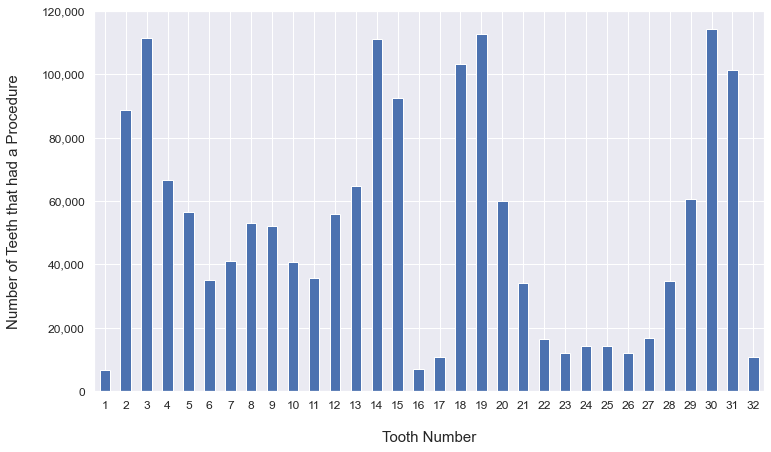

In [168]:
%matplotlib inline
colors = ['#4c72b0']
sns.set_palette(colors)

# draw bar chart showing the number of procedures performed on each tooth (number)
ax = tooth_count_df.plot.bar(figsize=(12,7)) 

# rotate the ticks on the x axis
plt.xticks(rotation=0)

# configure labels
# note the use of '\n' to create space between ticks and labels
ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)
ax.tick_params(labelsize='large')


ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
ax.get_legend().remove() # remove legend
plt.savefig("figures/tooth-count-per-tooth.png", dpi=600, bbox_inches="tight")
plt.show()

## plot total number of distinct teeth by tooth type that underwent a procedure by gender

In [40]:
patient_df = pds.read_csv('triplestore-patient-info.tsv', sep='\t') # load patient info

In [170]:
tooth_gender_query = """
select
    tooth_num, gender
from
    tooth_df
inner join
    patient_df
on
    tooth_df.patient_id = patient_df.patient_id
order by
    tooth_num
"""
tooth_gender_df = sqldf(tooth_gender_query)

In [172]:
q = """
select 
    tooth_num, gender, count(*) as num_teeth
from
    tooth_gender_df
group by
    tooth_num, gender
order by
    tooth_num
"""
tooth_gender_count_df = sqldf(q)

In [173]:
# temp_df.set_index('tooth_num', inplace=True)
tooth_gender_count_df.head()

,tooth_num,gender,num_teeth
0,1,female,2956
1,1,male,3623
2,2,female,48644
3,2,male,38915
4,3,female,62118


/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


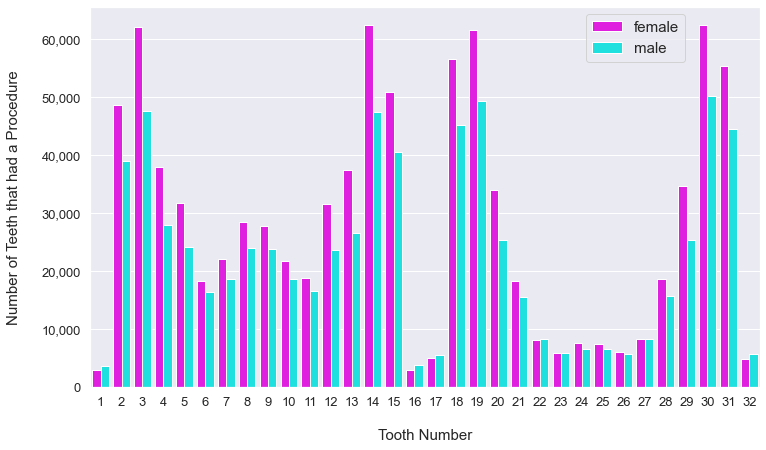

In [188]:
%matplotlib inline
colors = ['magenta', 'cyan']
sns.set_palette(colors)
# sns.set(font_scale=1)

plt.figure(figsize=(12,7))
ax = sns.barplot(x='tooth_num', y='num_teeth', hue="gender",data=tooth_gender_count_df)

ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)
ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
plt.savefig("figures/tooth-count-per-tooth-by-gender.png", dpi=600, bbox_inches="tight")
plt.show()

## create table with tooth number totals for females, males, and all

In [175]:
tooth_gender_count_df.head()

,tooth_num,gender,num_teeth
0,1,female,2956
1,1,male,3623
2,2,female,48644
3,2,male,38915
4,3,female,62118


In [197]:
female_tooth_count = tooth_gender_count_df.query("gender == 'female'")
male_tooth_count = tooth_gender_count_df.query("gender == 'male'")

In [207]:
gender_count_table = pds.merge(female_tooth_count, male_tooth_count, how='inner', on='tooth_num').drop_duplicates()
gender_count_table.drop(columns=['gender_x', 'gender_y'], inplace=True)
gender_count_table.rename(columns={'num_teeth_x': 'female', 'num_teeth_y': 'male'}, inplace=True)

In [208]:
gender_count_table.head()

,tooth_num,female,male
0,1,2956,3623
1,2,48644,38915
2,3,62118,47690
3,4,37956,27955
4,5,31684,24125


In [210]:
all_tooth_count_table = pds.merge(gender_count_table, tooth_count_df, how='inner', on='tooth_num').drop_duplicates()
all_tooth_count_table['sum_female_male'] = all_tooth_count_table.female + all_tooth_count_table.male
all_tooth_count_table.rename(columns={'num_teeth': 'all teeth'}, inplace=True)
all_tooth_count_table.head()

,tooth_num,female,male,all teeth,sum_female_male
0,1,2956,3623,6700,6579
1,2,48644,38915,88629,87559
2,3,62118,47690,111261,109808
3,4,37956,27955,66586,65911
4,5,31684,24125,56347,55809


In [211]:
tooth_gender_df.gender.unique()

array(['female', 'male'], dtype=object)